In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# out packages
from emissions.data import load_data, clean_data, split
from emissions.utils import *
from emissions.trainer import Trainer

# import data

In [3]:
df = load_data()
df = clean_data(df)
df.head()

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 165732

Records where ODOMETER = 0: 796

Records after droping rows where ODOMETER is missing: 164855

Records after droping rows where MILE_YEAR > 40,000: 163891

Records in output data:163891

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10194
Unique vehicles in Pass: 78573
['VEHICLE_TYPE' 'MODEL_YEAR' 'VEHICLE_AGE' 'MILE_YEAR' 'GVWR'
 'ENGINE_SIZE' 'TRANS_TYPE' 'TEST_TYPE' 'RESULT' 'MAKE'
 'ENGINE_WEIGHT_RATIO' 'SPORT' 'TEST_SDATE']


,VEHICLE_TYPE,MODEL_YEAR,VEHICLE_AGE,MILE_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,TEST_TYPE,RESULT,MAKE,ENGINE_WEIGHT_RATIO,SPORT,TEST_SDATE
0,3,2011,4,3637.25,6700.0,3700,A,I,0,dodge,0.55,0,2013-01-02 07:46:00
1,1,2002,13,12142.85,3125.0,2000,A,I,0,acura,0.64,0,2013-01-02 08:58:00
2,1,2001,14,12862.07,3875.0,2300,A,I,1,saab,0.59,0,2013-01-02 09:09:00
3,1,1996,19,7041.84,3625.0,3000,A,I,0,mercury,0.83,0,2013-01-02 09:10:00
4,1,2008,7,16336.71,2750.0,1600,A,I,0,chevrolet,0.58,0,2013-01-02 09:15:00


# check the features first

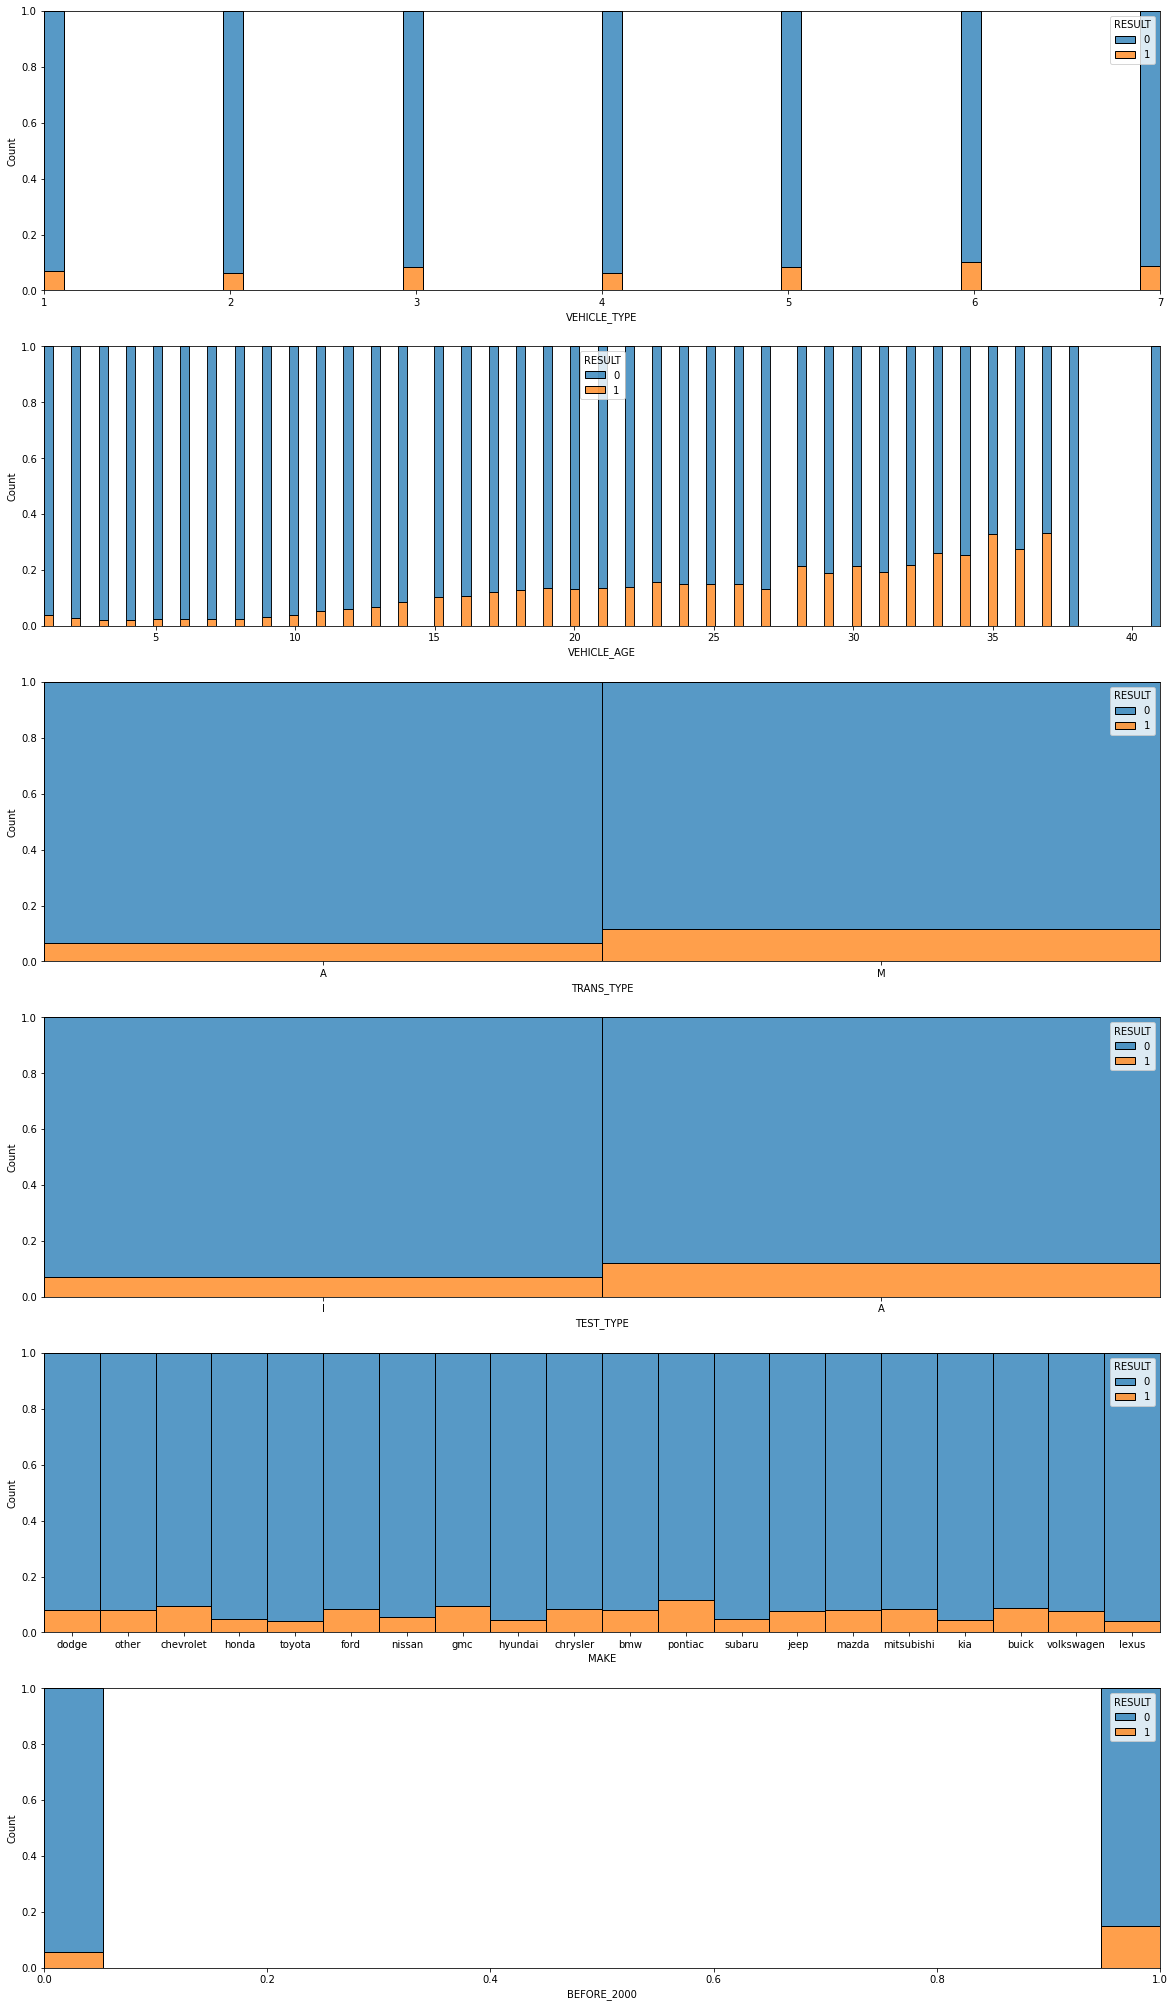

In [4]:
# categorical columns
cols = ['VEHICLE_TYPE', 'VEHICLE_AGE', 'TRANS_TYPE', 'TEST_TYPE', 'MAKE', 'BEFORE_2000']
fig, axs = plt.subplots(6, 1, figsize=(20, 36))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', multiple='fill', ax=ax)

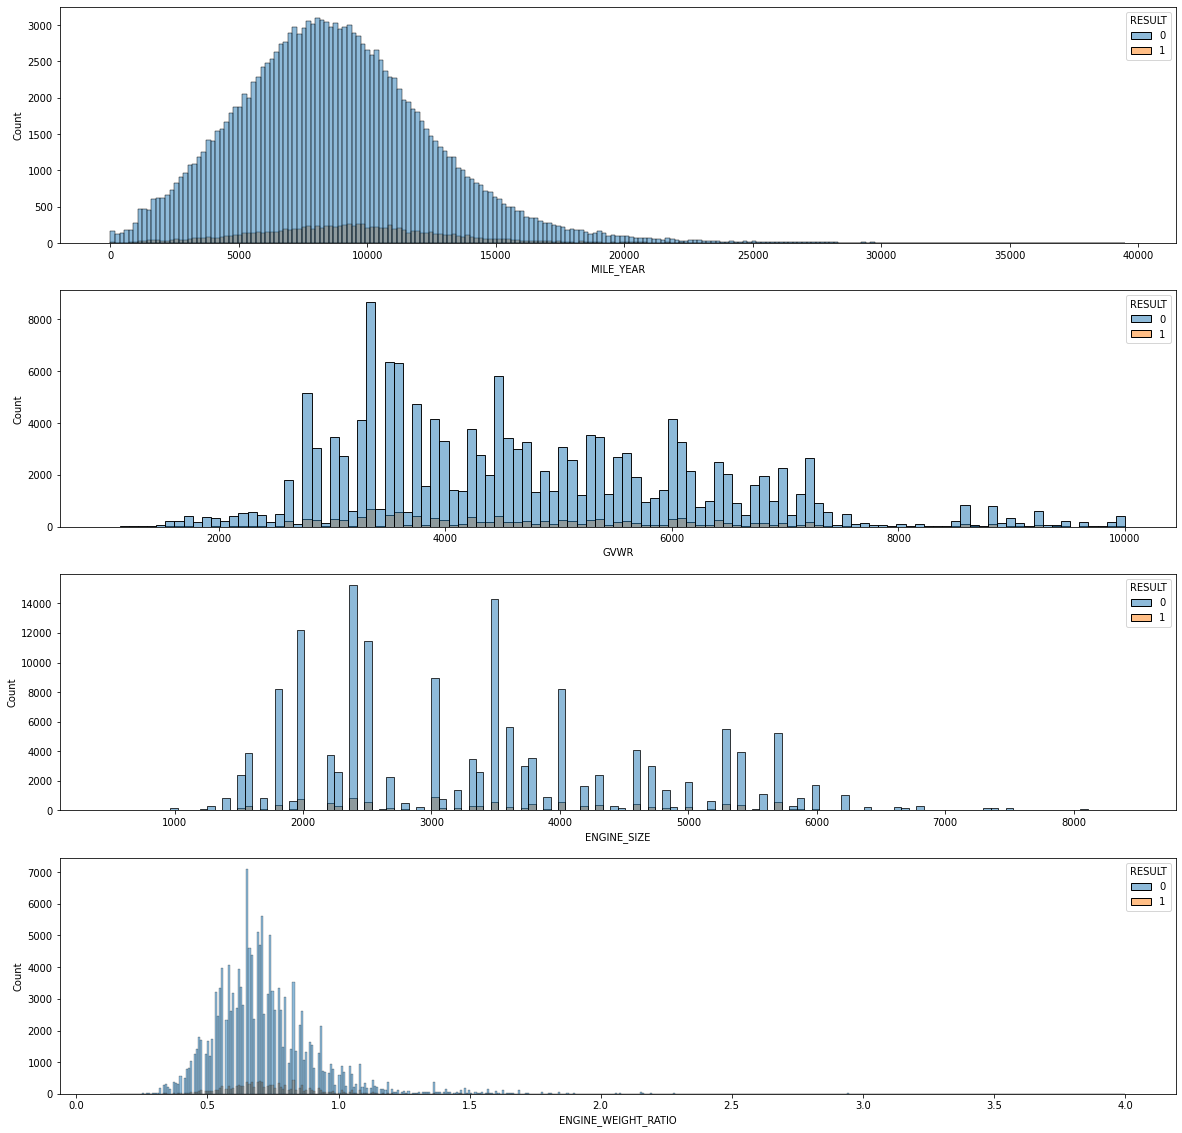

In [5]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO']
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', ax=ax)

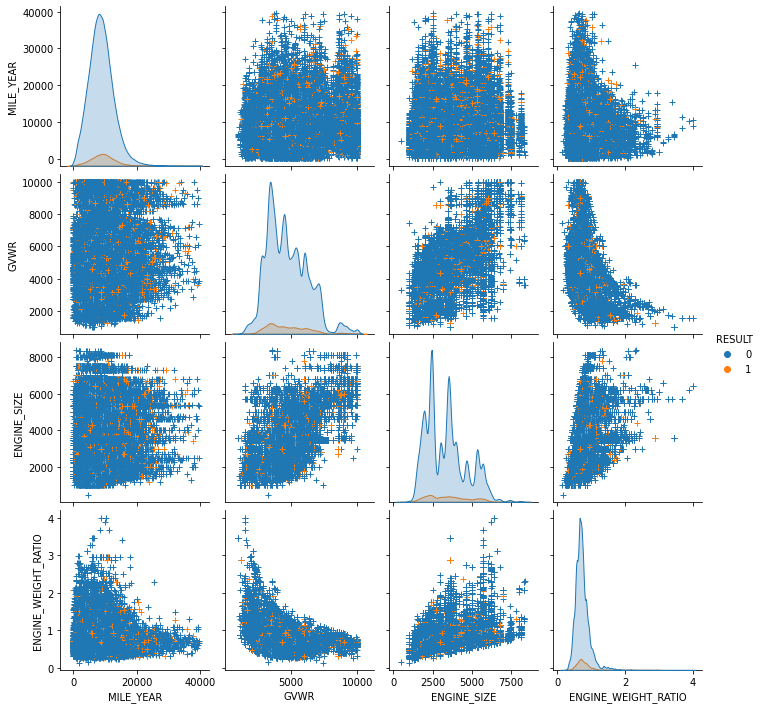

In [6]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO', 'RESULT']
sns.pairplot(data=df[cols], 
             hue='RESULT',
             plot_kws=dict(marker="+", linewidth=1, edgecolor=None));

# Train test split

In [4]:
X_train, X_test, y_train, y_test = split(df)

----------------data splitted into train test----------------
Share of Pass and Fail in train set:
Pass: 7%
Fail: 93%
Share of Pass and Fail in test set:
Pass: 7%
Fail: 93%


# Baseline model 1:  all vehicles with age > 16 will fail the test
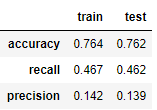

In [8]:
X_train.join(y_train).groupby('RESULT').VEHICLE_AGE.describe()

,count,mean,std,min,25%,50%,75%,max
RESULT,,,,,,,,
0,124182.0,11.871487,6.155406,1.0,7.0,11.0,16.0,41.0
1,9448.0,16.370555,6.472697,1.0,12.0,16.0,20.0,37.0


In [9]:
# train
train = {}
y_pred = (X_train.VEHICLE_AGE > 16).astype('int')
y_true = y_train
train['accuracy'] = round(accuracy_score(y_true, y_pred), 3)
train['recall'] = round(recall_score(y_true, y_pred), 3)
train['precision'] = round(precision_score(y_true, y_pred), 3)

# test
test = {}
y_pred = (X_test.VEHICLE_AGE > 16).astype('int')
y_true = y_test
test['accuracy'] = round(accuracy_score(y_true, y_pred), 3)
test['recall'] = round(recall_score(y_true, y_pred), 3)
test['precision'] = round(precision_score(y_true, y_pred), 3)

pd.DataFrame({'train':train, 'test':test})

,train,test
accuracy,0.764,0.762
recall,0.467,0.462
precision,0.142,0.139


# Baseline model 2: VEHICLE_AGE + MAKE 🚀🚀

## Question for Client

When we train our model to perform as good as possible, we need know what is your preference in the following trade off.

**trade off**: "capturing as much as vehicles that will fail the test" vs "reducing as much incorrect predictions as possible"

for instance

Our preliminary system for example can capture 70% of polluting vehicles, but 88% of the drivers called in for emission test will actually pass the test. When we increase 70% to 75%, meaning capturing 5% more polluting vehicles, we will have to sacrifice our accuracy, meaning, instead of 88%, now we will have 89% of vehicles that predicted to fail the test will actually pass the test.

So, what would you prefer: capturing as much as polluting vehicles while creating some false alarms OR limiting false alarm rate while missing out some polluting vehicles. 

## utility functions

In [10]:
def scoring_table(search, param_index):
    """
    takes grid search output and index of best params
    returns a scoring table
    """
    result = search.cv_results_
    tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][param_index], 
                           'recall': result['mean_train_recall'][param_index],
                           'precision': result['mean_train_precision'][param_index]}, 
                  'val':{'accuracy': result['mean_test_accuracy'][param_index], 
                           'recall': result['mean_test_recall'][param_index],
                           'precision': result['mean_test_precision'][param_index]}
                 })

    y_pred = search.best_estimator_.predict(X_test[cols])
    y_true = y_test
    tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
    tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
    tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
    return tmp.round(3)

In [11]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, X_train, y_train, scoring='recall'):
    """takes a model, X_train, y_train and plots learning curve"""

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X_train, 
                                                            y_train, 
                                                            train_sizes=np.linspace(0.05, 1, 20),
                                                            cv=cv,
                                                            scoring=scoring,
                                                            n_jobs=-1
                                                           )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Train')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1)

    plt.plot(train_sizes, test_scores_mean, label = 'Val')
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1)
    plt.legend()
    plt.ylabel('score')
    plt.xlabel('train sizes')
    if scoring=='recall':
        plt.ylim(0.6, 1)

## recall
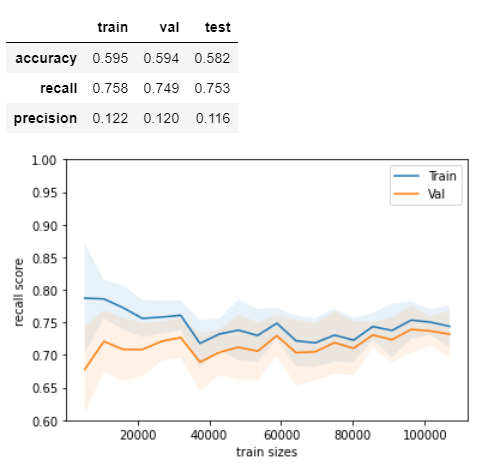


In [5]:
cols = ['VEHICLE_AGE', 'MAKE']
X_train[cols].head()

,VEHICLE_AGE,MAKE
117749,15,toyota
132007,5,ford
81705,14,bmw
140292,2,jeep
161073,18,jeep


In [6]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.746013522801671)

In [7]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.746014,0.748140
1,3,0.727663,0.731229
6,8,0.726586,0.737465
7,9,0.721191,0.734107
8,10,0.720759,0.734791


,train,val,test
accuracy,0.595,0.594,0.582
recall,0.758,0.749,0.753
precision,0.122,0.120,0.116


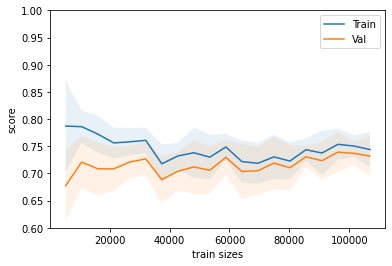

In [15]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 6)

## precision
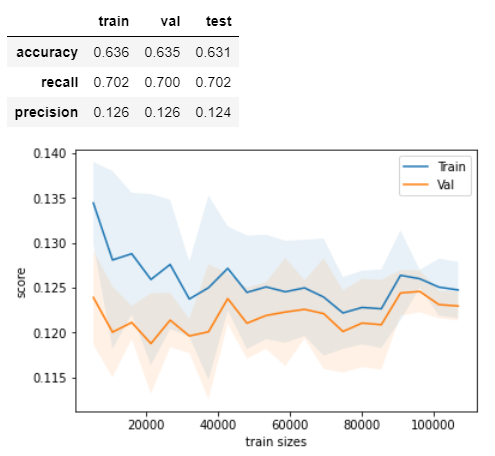


In [16]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='precision',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 5}, 0.1259884718423865)

In [17]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_precision', 
                      'mean_train_precision']].sort_values('mean_test_precision', ascending=False).head(5)

,param_model__max_depth,mean_test_precision,mean_train_precision
3,5,0.125988,0.126496
2,4,0.125922,0.126165
10,12,0.124533,0.126767
4,6,0.124441,0.125541
11,13,0.124350,0.127102


,train,val,test
accuracy,0.636,0.635,0.631
recall,0.702,0.700,0.702
precision,0.126,0.126,0.124


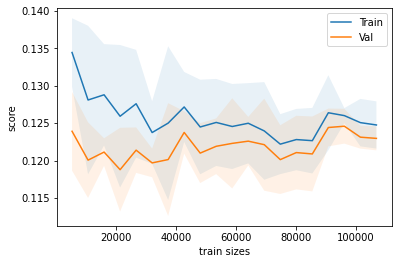

In [18]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train, scoring='precision')
scoring_table(search, 3)

## accuracy
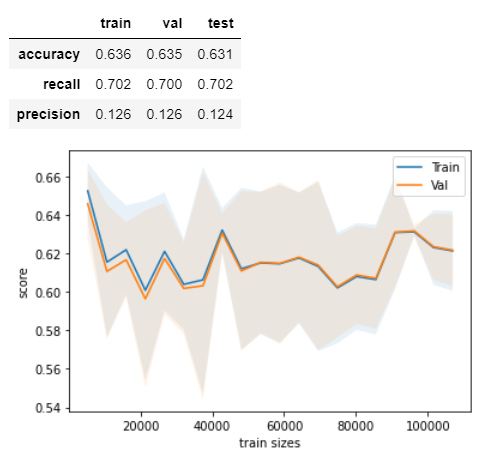


In [19]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='accuracy',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 5}, 0.6350594926289006)

In [20]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_accuracy', 
                      'mean_train_accuracy']].sort_values('mean_test_accuracy', ascending=False).head(5)

,param_model__max_depth,mean_test_accuracy,mean_train_accuracy
3,5,0.635059,0.635834
2,4,0.633690,0.634132
4,6,0.626716,0.627864
11,13,0.625167,0.627143
10,12,0.624620,0.626031


,train,val,test
accuracy,0.636,0.635,0.631
recall,0.702,0.700,0.702
precision,0.126,0.126,0.124


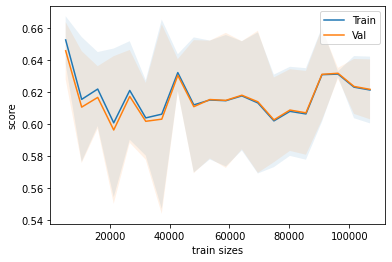

In [21]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train, scoring='accuracy')
scoring_table(search, 3)

# Evaluate features


## Tree 1.1: VEHICLE_AGE + TRANS_TYPE

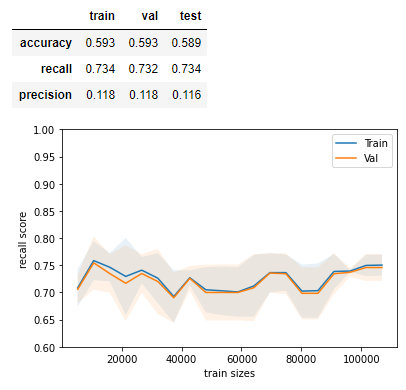


In [22]:
cols = ['VEHICLE_AGE', 'TRANS_TYPE'] 
X_train[cols].head()

,VEHICLE_AGE,TRANS_TYPE
27899,19,A
31944,14,A
29361,12,A
138648,7,A
51342,13,A


In [23]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TRANS_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [24]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
3,5,0.687977,0.687976
4,6,0.687977,0.687976
5,7,0.687977,0.687976
6,8,0.687977,0.687976


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


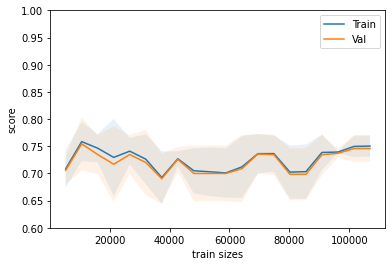

In [25]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.2: VEHICLE_AGE + MILE_YEAR 🚀🚀🚀



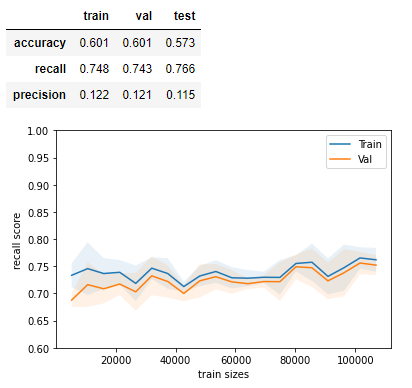

In [9]:
cols = ['VEHICLE_AGE', 'MILE_YEAR']
X_train[cols].head()

,VEHICLE_AGE,MILE_YEAR
117749,15,6528.80
132007,5,23601.60
81705,14,8469.64
140292,2,2927.00
161073,18,4657.28


In [10]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 4}, 0.7515194512594332)

In [14]:
search.best_index_

2

In [11]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_max_depth,mean_test_recall,mean_train_recall
2,4,0.751519,0.755085
0,2,0.746014,0.748140
3,5,0.718591,0.722882
5,7,0.715787,0.736926
6,8,0.710388,0.738702


,train,val,test
accuracy,0.592,0.592,0.568
recall,0.755,0.752,0.770
precision,0.120,0.120,0.114


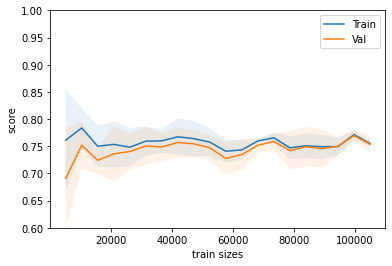

In [15]:
from emissions.utils import plot_learning_curve, scoring_table
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, X_test[cols], y_test)

## Tree 1.3: VEHICLE_AGE + VEHICLE_TYPE
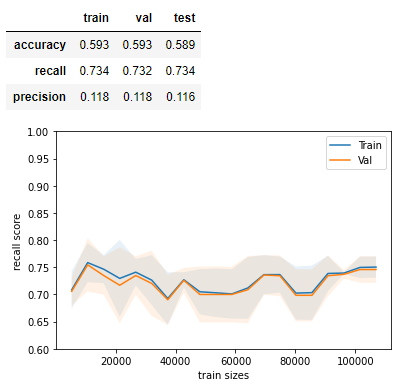

In [30]:
cols = ['VEHICLE_AGE', 'VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,VEHICLE_TYPE
27899,19,1
31944,14,1
29361,12,4
138648,7,4
51342,13,3


In [31]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [32]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
7,9,0.715815,0.720094
8,10,0.715709,0.719976
9,11,0.715180,0.719835
6,8,0.715074,0.719294


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


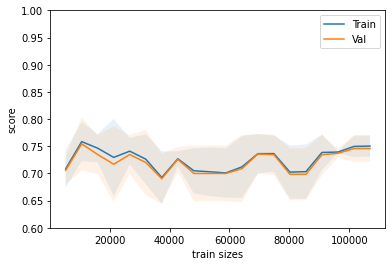

In [33]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.4: VEHICLE_AGE + MAKE_VEHICLE_TYPE

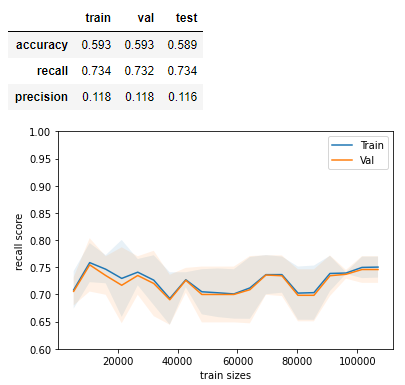


In [34]:
cols = ['VEHICLE_AGE', 'MAKE_VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,MAKE_VEHICLE_TYPE
27899,19,other1
31944,14,mazda1
29361,12,honda4
138648,7,jeep4
51342,13,ford3


In [35]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE_VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 18, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [36]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
3,5,0.715708,0.719164
13,15,0.712951,0.736265
14,16,0.710623,0.736594
1,3,0.708515,0.712202


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


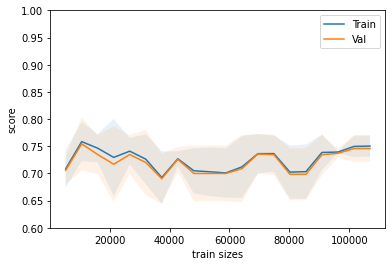

In [37]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.5: VEHICLE_AGE + ENGINE_WEIGHT_RATIO

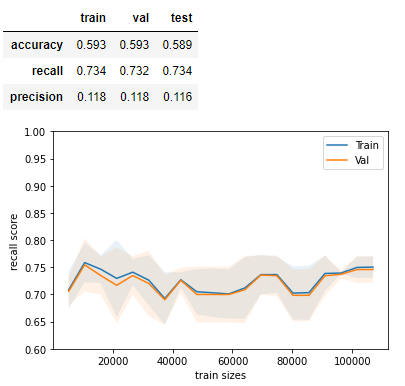


In [38]:
cols = ['VEHICLE_AGE', 'ENGINE_WEIGHT_RATIO']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_WEIGHT_RATIO
27899,19,1.19
31944,14,0.67
29361,12,0.74
138648,7,0.98
51342,13,0.94


In [39]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 2}, 0.7324321809703166)

In [40]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()


,param_max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
4,6,0.703536,0.709462
6,8,0.702266,0.719906
5,7,0.700891,0.710121
2,4,0.699726,0.700689


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


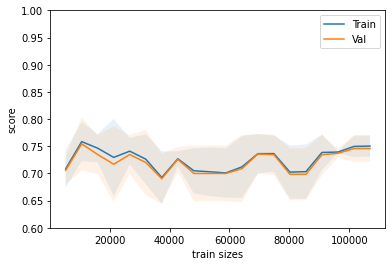

In [41]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.6: VEHICLE_AGE + ENGINE_SIZE

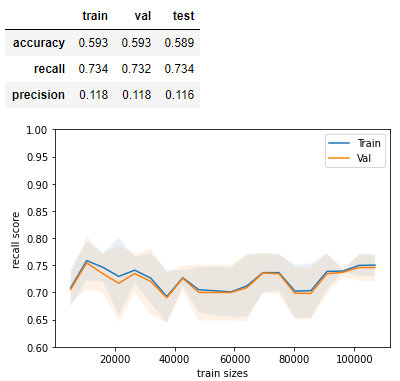


In [42]:
cols = ['VEHICLE_AGE', 'ENGINE_SIZE']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_SIZE
27899,19,4600
31944,14,2000
29361,12,3500
138648,7,6400
51342,13,4000


In [43]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 2}, 0.7324321809703166)

In [44]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
5,7,0.711578,0.722752
4,6,0.711054,0.717212
6,8,0.709567,0.727268
3,5,0.705651,0.714084


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


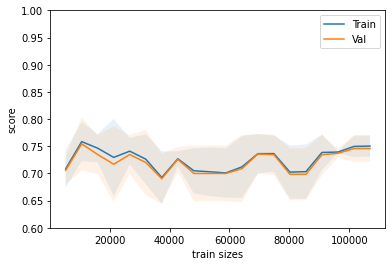

In [45]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

## Tree 1.7: VEHICLE_AGE + TEST_TYPE

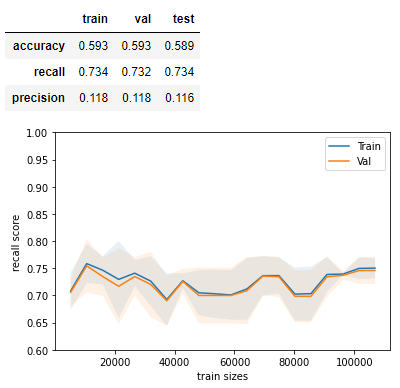


In [46]:
cols = ['VEHICLE_AGE', 'TEST_TYPE']
X_train[cols].head()

,VEHICLE_AGE,TEST_TYPE
27899,19,I
31944,14,I
29361,12,I
138648,7,I
51342,13,I


In [47]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TEST_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 2}, 0.7324321809703166)

In [48]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
0,2,0.732432,0.733947
1,3,0.684167,0.684166
2,4,0.684061,0.684531
3,5,0.683744,0.684778
4,6,0.683532,0.684848


,train,val,test
accuracy,0.593,0.593,0.589
recall,0.734,0.732,0.734
precision,0.118,0.118,0.116


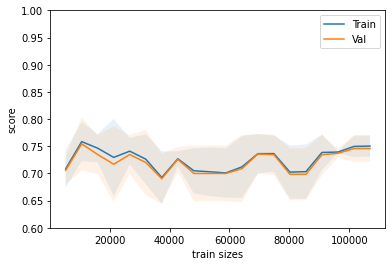

In [49]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 0)

# Tree 2 : VEHICLE_AGE + MILE_YEAR + MAKE  + other features?

In [55]:
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'BEFORE_2000', 'MAKE']
X_train[cols].head()

,VEHICLE_AGE,MILE_YEAR,BEFORE_2000,MAKE
27899,19,6234.95,1,other
31944,14,11399.21,0,mazda
29361,12,9055.67,0,honda
138648,7,12125.00,0,jeep
51342,13,9936.46,0,ford


In [56]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(8, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=10,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 9}, 0.7081952291274326)

In [57]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()


,param_model__max_depth,mean_test_recall,mean_train_recall
1,9,0.708195,0.755410
0,8,0.707450,0.739416
2,10,0.701313,0.767429
3,11,0.683429,0.769004
4,12,0.671998,0.784575


,train,val,test
accuracy,0.647,0.640,0.657
recall,0.755,0.708,0.685
precision,0.137,0.128,0.130


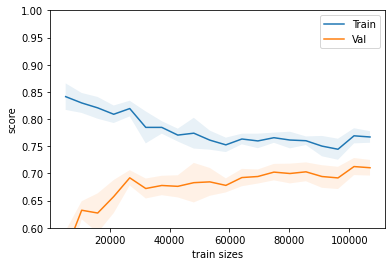

In [58]:
plot_learning_curve(search.best_estimator_, X_train[cols], y_train)
scoring_table(search, 1)

# Forest : VEHICLE_AGE + MILE_YEAR + MAKE  + other features?